In [ ]:
import h5py
import numpy as np
import torch
import torch.utils.data as data
from scipy.io import savemat

from datasets.wv3 import WV3Datasets
from datasets.HISR import HISRDataSets
from model import build_network
from utils import AnalysisPanAcc, viz_batch, load_config, res_image

device = 'cuda:0'
path = '/Data2/DataSet/pansharpening/test1_mulExm1258.mat'
# path = '/Data2/DataSet/pansharpening_2/test_data/WV3/test_wv3_multiExm1.h5'
# path = '/Data2/DataSet/HISR/CAVE/test_cave(with_up)x4.h5'
dataset_type = 'wv3'
bs = 8

# model = VanillaPANNet(8, 32).to('cuda:0')

name = 'dcformer'
subarch = 'reduce'

if name in ['panformer', 'dcformer']:
    config = load_config(name)
    full_arch = name + '_' + subarch
    model = build_network(full_arch, **config['network_configs'][full_arch])
else:
    config = load_config(name)
    model = build_network(name, **config['network_configs'])

# ======================worldview3 checkpoint============
# p = './weight/pannet_3vskemk0.pth'  # pannet
# p = './weight/panformer_44v9p9t3.pth'  # gau
# p = './weight/panformer_1bxe3b0v.pth'  # restormer
# p = './weight/fusionnet_30zvejpu.pth'  # fusionnet
# p = './weight/dcformer_2t9tw637.pth'  # dcformer with attention grad
# p = './weight/dcformer_22vv4nzx.pth'  # dcformer sota
# p = './weight/dcformer_2vt2nluz.pth'  # dcformer_dpw without attention grad
# p = './weight/dcformer_1thsgpdv.pth'  # dcformer_dpw with partially switch qkv
# p = './weight/dcformer_3jhs05so.pth'  # dcformer_dpw with fully switch qkv
# p = './weight/dcformer_3vg8vlh9.pth'  # dcformer_dpw with only switch qkv in fuse layer, depth = [4, [4, 4], [4, 4, 4]] and another cross-attn in FPN between b1_in and b2_in(after CFSBlock)
# p = './weight/dcformer_2azisub2.pth'  # dcformer with less depth (all depth is 2)
# p = './weight/dcformer_3baebtne.pth'  # dcformer_dpw [4, [4, 3], [4, 3, 2]]
# p = './weight/dcformer_16hbiq2c.pth'  # dcformer_woo [4, [4, 3], [4, 3, 2]]
# p = './weight/dcformer_19e6v9x5.pth'  # dcformer_reduce
p = './weight/dcformer_o7woscjm.pth'  # dcfomer use avgpool
# p = './weight/dcformer_2enz0i9d.pth'  # dcformer dynamic kernel
# ========================================================

# ================HISI CAVE checkpoint=============
# p = './weight/dcformer_37xwviyh.pth'  # dcformer_reduce on HISI CAVE dataset
# =================================================

params = torch.load(p, map_location=device)
# odict = OrderedDict()
# for k, v in params['model'].items():
#    odict['module.' + k] = v
model.load_state_dict(params['model'])
model = model.to(device)
model.eval()

d = h5py.File(path)
if dataset_type == 'wv3':
    gt, ms, lms, pan = np.asarray(d['gt']), np.asarray(d['ms']), np.asarray(d['lms']), np.asarray(d['pan'])
    pan = pan[:, np.newaxis, ...]
    ms, lms, gt = map(lambda x: x.transpose([0, 3, 1, 2]), [ms, lms, gt])
    d = dict(gt=gt, ms=ms, lms=lms, pan=pan)
    ds = WV3Datasets(d, hp=False)
elif dataset_type == 'hisi':
    d = h5py.File(path)
    ds = HISRDataSets(d)
else:
    raise NotImplementedError
dl = data.DataLoader(ds, batch_size=bs, shuffle=True)
analysis = AnalysisPanAcc()


In [ ]:
from model.module.attention import ReducedAttention

In [ ]:
import torch.nn as nn

def hook_model(model: nn.Module, saved_tensor, hook_class):
    def feature_hook(m, input_x, output):
        # forward hook
        saved_tensor.append([input_x, output, m])

    hooks = []
    for n, m in model.named_modules():
        if isinstance(m, hook_class):
            hooks.append(m.register_forward_hook(feature_hook))
    return model, hooks

attns = []
model, hooks = hook_model(model, attns, ReducedAttention)

In [ ]:
all_sr = []
with torch.no_grad():
    for i, (pan, ms, lms, gt) in enumerate(dl, 1):
        pan, ms, lms, gt = pan.to(device).float(), ms.to(device).float(), lms.to(device).float(), gt.to(device).float()

        sr = model.val_step(ms, lms, pan)
        sr1 = sr.detach().cpu().numpy()
        all_sr.append(sr1)

        analysis(gt, sr)

        res = res_image(gt, sr)
        break

In [ ]:
import einops

def crop_inference(model,
                   xs,
                   crop_size = (16, 64, 64),
                   stride = (8, 32, 32)):
    # only support CAVE dataset
    # input shape: 128, 512, 512

    # xs: (hsi_lr, hsi_up, rgb)

    torch.backends.cudnn.enable = True
    torch.backends.cudnn.benchmark = True

    # preprocessing
    crop_xs = []
    ncols = []
    bs, out_c, _, _ = xs[0].shape
    _, _, out_h, out_w = xs[-1].shape
    for i in range(len(xs)):
        x = xs[i]
        _, c, h, _ = x.shape  # assume h equals w
        crop = crop_size[i]
        s = stride[i]

        ncol = (h - crop) // s
        ncols.append(ncol)
        crop_x = F.unfold(x, crop, stride=s)
        crop_x = einops.rearrange(crop_x, 'b (c k l) m -> m b c k l', k=crop, l=crop, c=c)
        crop_xs.append(crop_x)

    # model inference
    model.eval()
    out = []
    for i in range(crop_xs[0].size(0)):
        input = [crop_xs[j][i].cuda(0) for j in range(len(xs))]
        out.append(model.val_step(*input).detach().cpu())  # [bs * 225, 31, 64, 64]
        del input
        torch.cuda.empty_cache()
    # input: 255*[b, 31, 64, 64]
    out = torch.cat(out, dim=0)

    # postprocessing
    out = einops.rearrange(out, '(m b) c k l -> b (c k l) m', b=bs, k=crop_size[-1], l=crop_size[-1], c=out_c)
    output = F.fold(out, output_size=(out_h, out_w),
                    kernel_size=(crop_size[-1], crop_size[-1]),
                    dilation=1,
                    padding=0,
                    stride=(stride[-1], stride[-1]))

    # ncol = ncols[-1]
    # out = out.view(bs, -1, out_c, crop_size[-2], crop_size[-1])  # [bs, 225, 64, 64]
    # output = torch.zeros(bs, out_c, out_h, out_w)
    # for bi in range(bs):
    #     for i in range(ncol):
    #         for j in range(ncol):
    #             y = out[bi]  # [255, 64, 64]

    return output

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

for pan, ms, lms, gt in dl:
    break

ms = F.interpolate(ms, scale_factor=4)
lms = F.interpolate(lms, scale_factor=4)
pan = F.interpolate(pan, scale_factor=4)

sr = crop_inference(model, [ms.float(), lms.float(), pan.float()])

plt.imshow(gt[0, 0].detach().cpu().numpy())
plt.show()

plt.imshow(sr[0].mean(0).detach().cpu().numpy())
plt.show()

In [ ]:
from torch.nn import functional as F
from einops import rearrange

def qk_relation_map(m, tgt, mem, pos=None):
    b, c, h, w = tgt.shape
    _, c, h2, w2 = mem.shape
    interp_mem = m.match_c(F.interpolate(mem, size=tgt.shape[-2:]))
    residual = m.reduce(tgt - interp_mem)

    q = m.q_dw(m.q(tgt))
    kv = m.kv_dw(m.kv(residual))
    k, v = kv.chunk(2, dim=1)

    # propagate residual information to tgt
    q = rearrange(q, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    k = rearrange(k, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    v = rearrange(v, 'b (head c) h w -> b head (h w) c', head=m.num_heads)
    
    q = torch.nn.functional.normalize(q, dim=-1)
    k = torch.nn.functional.normalize(k, dim=-1)
    attn = (q @ k.transpose(-2, -1)) * m.temperature  # [b, h, h1w1, h2w2]
    attn = attn.softmax(dim=-1)
    # print(q.shape, k.shape)
    
    # q, k relation
    # print(attn.shape)
    if pos is None:
        pos = attn.shape[-2] // 2
    relation = attn[..., pos, :]  # [b, head, h//4*w//4]
    # print(relation.shape)
    relation = relation.view(b, m.num_heads, h//4, w//4)
    
    return relation, attn


In [ ]:
index = 4
sample_index = 2
head_index = 0

input_tgt = attns[index][0][0]
input_mem = attns[index][0][1]
output = attns[index][1]
m = attns[index][2]

mean_tgt = input_tgt.mean(1, keepdim=True)
mean_mem = F.interpolate(input_mem.mean(1, keepdim=True), size=mean_tgt.shape[-2:])

#====in module====
interp_mem = F.interpolate(input_mem, size=input_tgt.shape[-2:])
matched_interp_mem = m.match_c(interp_mem)
residual = m.reduce(input_tgt - matched_interp_mem)
#=================

import matplotlib.pyplot as plt

print(mean_tgt[index, 0].shape)
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20, 50))

for ax in axes:
    ax.set_axis_off()
axes[0].imshow(mean_tgt[sample_index, 0].cpu().numpy(), 'gray')
axes[0].set_title(f'tgt: {tuple(input_tgt.shape[-2:])}')
axes[1].imshow(mean_mem[sample_index, 0].cpu().numpy(), 'gray')
axes[1].set_title(f'mem: {tuple(input_mem.shape[-2:])}')
axes[2].imshow(pan[sample_index, 0].cpu().numpy(), 'gray')
axes[2].set_title('pan')

axes[3].imshow(residual[sample_index].mean(0).detach().cpu().numpy(), 'hot')
axes[3].set_title('residual')

qk_relation, attn = qk_relation_map(m, input_tgt, input_mem)
axes[4].imshow(qk_relation.mean(0)[head_index, ...].detach().cpu().numpy(), 'hot')
axes[4].set_title(f'qk relation: {qk_relation.size(-2), qk_relation.size(-1)}')

# axes[5].imshow(attn[sample_index, head_index, ...].detach().cpu().numpy(), 'hot')
# axes[5].set_title(f'attn: {attn.size(-2), attn.size(-1)}')

In [ ]:
r = np.random.randn(5, 5)
r_f = r.flatten()

r_f[18], r[3, 3]

In [ ]:
attn.shape

In [ ]:
64*64*0.8+10

In [ ]:
plt.imshow(gt[sample_index].cpu().numpy()[[0, 2, 4], ...].transpose([1, 2, 0]))

# 重新写入融合图片

In [1]:
import h5py
import numpy as np
import os
import os.path as osp
import scipy.io as io
from tqdm import tqdm


file = r'/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref.mat'

name = file.split('/')[-1].strip('.mat')
path = f'/Data3/cao/ZiHanCao/exps/panformer/visualized_img/{name}'
save_prefix = 'output_mulExm_'
if not osp.exists(path):
    os.mkdir(path)
    print(f'make dir {name}')
else:
    print(f'exist dir {name}')

make dir data_hyper_transformer_cave_ref


In [2]:
mat_file = io.loadmat(file)
print(f'has keys: {mat_file.keys()}')

sr = mat_file.get('sr')
if sr is None:
    print('has no key sr')
else:
    bar = tqdm(range(sr.shape[0]))
    for i in bar:
        save_path = osp.join(path, save_prefix+f'{i}.mat')
        sr_i = np.transpose(sr[i, ...], [1,2,0])
        # print(sr_i.shape)
        save_d = {'sr': sr_i}
        io.savemat(save_path, save_d)
        bar.set_description(f'save {i}.mat')
        
        

has keys: dict_keys(['__header__', '__version__', '__globals__', 'sr', 'gt'])


  0%|          | 0/11 [00:00<?, ?it/s]

save 10.mat: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


find files in /Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_0.mat
shape as (512, 512, 31)
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_1.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_2.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_3.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_4.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_5.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_6.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref/output_mulExm_7.mat
/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_tra

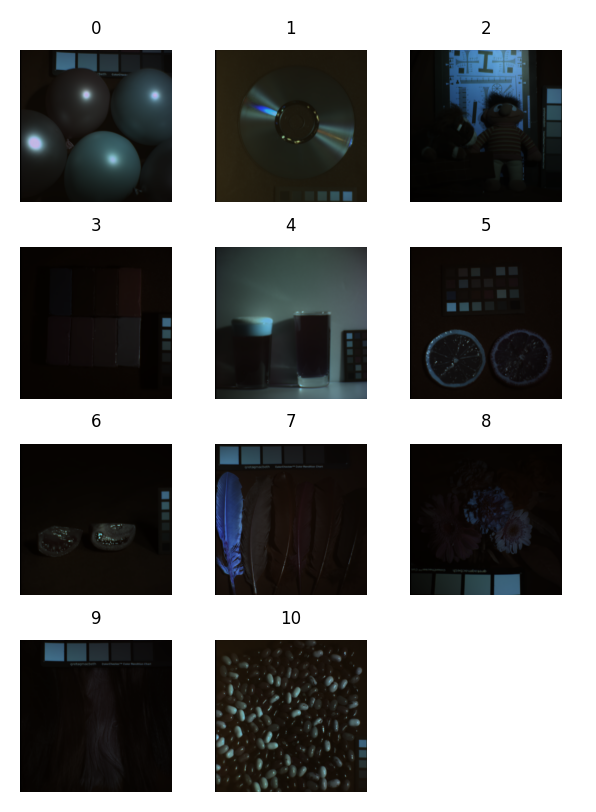

In [4]:
import numpy as np
import glob
import matplotlib.pyplot as plt

path = '/Data3/cao/ZiHanCao/exps/panformer/visualized_img/data_hyper_transformer_cave_ref'
const = 1
files = glob.glob(path+'/*.mat')
files = sorted(files, key=lambda x: int(os.path.basename(x).split('_')[-1].strip('.mat')))

print(f'find files in {path}')
f_len = len(files)
nrows = 4
ncols = np.ceil(f_len/4).astype('int')
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols, nrows), dpi=200)
axes = axes.flatten()
for ax in axes: ax.set_axis_off()
for i, f in enumerate(files):
    print(f)
    sr = io.loadmat(f).get('sr') / const
    sr=sr.clip(0, 1)
    show_sr = (sr[..., [0,1,2]]*255).astype('uint8')
    # for j in range(3):
    #     show_sr[..., j] = cv2.equalizeHist(show_sr[..., j])
    axes[i].imshow(show_sr)
    axes[i].set_axis_off()
    axes[i].set_title(f'{i}',fontsize=6)
    
    if i == 0:
        print(f'shape as {sr.shape}')
        
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
import h5py

path = "/media/office-401-remote/Elements SE/cao/ZiHanCao/datasets/HISI/new_harvard/test_harvard(with_up)x4_rgb.h5"

gt = h5py.File(path)['GT'][:]


In [11]:
gt = gt.transpose([0, 2, 3, 1])

In [12]:
from scipy.io import savemat

for i in range(gt.shape[0]):
    path = f'_gt/output_mulExm_{i}.mat'

    savemat(path, {'sr': gt[i]})
    print(gt[i].shape)

(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
(1000, 1000, 31)
